In [1]:
#!/usr/bin/python3

import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn
import missingno
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, average_precision_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.utils import shuffle

from imblearn.under_sampling import RandomUnderSampler

from tensorflow_addons import losses
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report

# Create the dataframe of the csv file
df = pandas.read_csv('../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

# Display summary of the dataframe
print(df.info())

# By manual inspection, we can confirm that the 'id' column can be removed as it does not contain any
# relevant information
df.drop('id', axis = 1, inplace = True)

df['gender'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

# Data Preprocessing

In [2]:
# Check the 'age' attribute values
df.age.sort_values()
temp_df_age = df[df['stroke'] == 1]['age']

# Check the least values of 'age' attribute
print(temp_df_age.nsmallest(6))

# The age with value '1.32' seems invalid, it will be better to drop the instances with very small values of age
df = df[df['age'] > 13]

162     1.32
245    14.00
182    32.00
118    38.00
133    38.00
49     39.00
Name: age, dtype: float64


<AxesSubplot:>

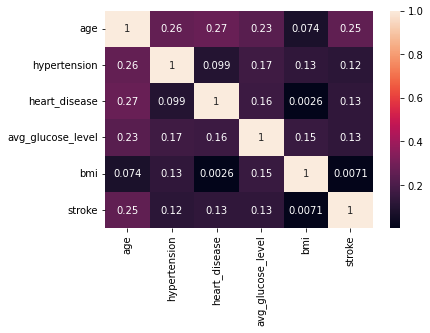

In [3]:
# Check the correlation among features
seaborn.heatmap(df.corr(), annot = True)

Number of rows in the dataframe: 4464
Number of missing values in bmi = 185
Column(s) with atleast one NULL value (missing value): ['bmi']


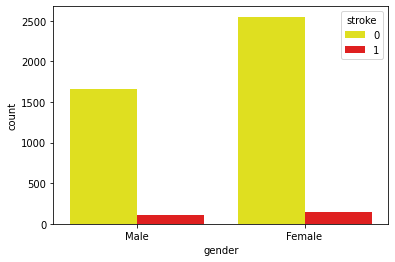

In [4]:
# Since there is only 1 row with the gender as 'Other', we can drop it as it won't be much relevant in the analysis and prediction
df = df.drop(df.loc[df['gender'] == 'Other'].index)

# Checks which columns in the dataset have atleast one null value
def find_columns_with_null_value(dataframe):
    cols_list = dataframe.columns
    n_rows = len(dataframe)
    result = []
    for i in range(len(cols_list)):
        if dataframe.count()[i] < n_rows:
            result.append(cols_list[i])
            print('Number of missing values in ' + str(cols_list[i]) + ' = ' + str(n_rows - dataframe.count()[i]))
    return result

'''
Fills the missing values in a column by the median value
Reference: https://stackoverflow.com/questions/18689823/pandas-dataframe-replace-nan-values-with-average-of-columns
'''
def fill_missing_values_by_median(dataframe, column_name):
    dataframe[column].fillna(dataframe[column].median(), inplace = True)
    return dataframe

# Checking relation between gender and stroke
seaborn.countplot(x='gender', data = df, hue = 'stroke', palette=['yellow',"red"])

# Number of rows in the dataframe
print('Number of rows in the dataframe: ' + str(len(df)))
print('Column(s) with atleast one NULL value (missing value): ' + str(find_columns_with_null_value(df)))

In [5]:
''' 
This function assumes that there does not exist any column in the dataset which has numerical
values and which is categorical

Reference: https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical
'''
def identify_categorical_columns(dataframe):
    cols_list = dataframe.columns
    numerical_cols_list = dataframe.select_dtypes('number').columns
    result = list(filter(lambda column: (column not in numerical_cols_list), set(cols_list)))
    return result

# Find out the columns which have categorical values
print('Categorical Columns: ' + str(identify_categorical_columns(df)))

Categorical Columns: ['ever_married', 'Residence_type', 'smoking_status', 'gender', 'work_type']


In [6]:
#Randomly shuffling the dataframe
# df = shuffle(df, random_state = 42)

'''
The attributes 'work_type' and 'smoking_status' have many possible values, so it will be better to encode these columns using one-hot encoding.

'gender', 'ever_married', and 'Residence_type' attributes can be transformed into binary features using the LabelEncoder.

References:
1. https://towardsdatascience.com/handling-categorical-data-the-right-way-9d1279956fc6
2. https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
3. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
'''

# Encoding the 'work_type' and 'smoking_status' attributes using one-hot encoding
temp_columns = pandas.get_dummies(df.work_type)
df.drop('work_type', axis = 1, inplace = True)
temp_df1 = df[[column for column in df.columns[:5]]]
temp_df1 = pandas.concat([temp_df1, temp_columns], axis = 1)
temp_df2 = pandas.get_dummies(df.smoking_status)
temp_df3 = df[[column for column in df.columns[5:8]]]
temp_df1 = pandas.concat([temp_df1, temp_df3, temp_df2, df['stroke']], axis = 1)

# Encoding the 'gender', 'ever_married' and 'Residence_type' attributes using label encoding
label_encoder = LabelEncoder()

temp_df1['gender'] = label_encoder.fit_transform(temp_df1['gender'])
temp_df1['ever_married'] = label_encoder.fit_transform(temp_df1['ever_married'])
temp_df1['Residence_type'] = label_encoder.fit_transform(temp_df1['Residence_type'])

df = temp_df1

df

,gender,age,hypertension,heart_disease,ever_married,Govt_job,Never_worked,Private,Self-employed,children,Residence_type,avg_glucose_level,bmi,Unknown,formerly smoked,never smoked,smokes,stroke
0,1,67.0,0,1,1,0,0,1,0,0,1,228.69,36.6,0,1,0,0,1
1,0,61.0,0,0,1,0,0,0,1,0,0,202.21,NaN,0,0,1,0,1
2,1,80.0,0,1,1,0,0,1,0,0,0,105.92,32.5,0,0,1,0,1
3,0,49.0,0,0,1,0,0,1,0,0,1,171.23,34.4,0,0,0,1,1
4,0,79.0,1,0,1,0,0,0,1,0,0,174.12,24.0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,0,0,1,0,0,1,83.75,NaN,0,0,1,0,0
5106,0,81.0,0,0,1,0,0,0,1,0,1,125.20,40.0,0,0,1,0,0
5107,0,35.0,0,0,1,0,0,0,1,0,0,82.99,30.6,0,0,1,0,0
5108,1,51.0,0,0,1,0,0,1,0,0,0,166.29,25.6,0,1,0,0,0


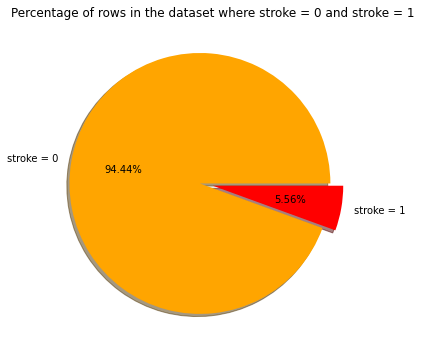

In [7]:
'''
Check whether the dataset is balanced or imbalanced in terms of output labels.
'''

data_balance_check_labels = ['stroke = 0', 'stroke = 1']
total_instances_per_value = df['stroke'].value_counts()
pie_chart_colors = ['orange', 'red']
plt.figure(figsize=(6,6))
plt.pie(total_instances_per_value, labels = data_balance_check_labels, shadow = 1, explode = (0.1, 0), autopct='%1.2f%%', colors = pie_chart_colors)
plt.title('Percentage of rows in the dataset where stroke = 0 and stroke = 1')
plt.show()

In [8]:
'''
This is the main problem in the dataset - the dataset is imbalanced. This might lead to overfit and the resulting model
will be biased towards predicting 'no stroke (stroke = 0)
'''
# Splitting the dataset into the train data (80%) and the test data (20%)
# Reference: https://stackoverflow.com/questions/42191717/scikit-learn-random-state-in-splitting-dataset

train_data, test_data = train_test_split(df, test_size = 0.2, random_state = 42)

# Separating the input features and the output label from the training data and the test data
X_train_data = train_data.copy()
X_train_data = X_train_data.drop('stroke', axis = 1)
# X_train_data = train_data[[column for column in train_data.columns[:-1]]]
#y_train_data = train_data[[train_data.columns[len(train_data.columns) - 1]]]
y_train_data = train_data[['stroke']]
#X_test_data = test_data[[column for column in test_data.columns[:-1]]]
#y_test_data = test_data[[test_data.columns[len(test_data.columns) - 1]]]
X_test_data = test_data.copy()
X_test_data = X_test_data.drop('stroke', axis = 1)
y_test_data = test_data[['stroke']]
'''
If there are any missing values in any column, fill them by the median value of that column.
If we do this before the train-test split, there is a possibility of data leakage.
References: 
1. https://www.analyticsvidhya.com/blog/2021/05/dealing-with-missing-values-in-python-a-complete-guide/
2. https://www.analyticsvidhya.com/blog/2021/07/data-leakage-and-its-effect-on-the-performance-of-an-ml-model/
'''
for column in find_columns_with_null_value(X_train_data):
    X_train_data = fill_missing_values_by_median(X_train_data, column)

for column in find_columns_with_null_value(X_test_data):
    X_test_data = fill_missing_values_by_median(X_test_data, column)
    
print(sum(y_train_data.values.ravel()))
print(sum(y_test_data.values.ravel()))


Number of missing values in bmi = 140
Number of missing values in bmi = 45
196
52


In [9]:
# Scale the train and test data
data_scaler = MinMaxScaler()
X_train_data_scaled = data_scaler.fit_transform(X_train_data)
X_test_data_scaled = data_scaler.transform(X_test_data)

In [10]:
# Oversample the training data using Synthetic Minority Oversampling Technique (SMOTE)
# Reference: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
smote_for_oversampling = SMOTE(random_state = 42)
X_train_oversampled, y_train_oversampled = smote_for_oversampling.fit_resample(X_train_data_scaled, y_train_data)
#X_test_data, y_test_data = smote_for_oversampling.fit_resample(X_test_data, y_test_data)
print(y_train_oversampled.value_counts())

# Random under-sampling removes the rows having majority class labels randomly
random_under_sampler = RandomUnderSampler(replacement = True, random_state = 42)

X_train_undersampled, y_train_undersampled = random_under_sampler.fit_resample(X_train_data_scaled, y_train_data)

print(y_train_undersampled.value_counts())

stroke
0         3375
1         3375
dtype: int64
stroke
0         196
1         196
dtype: int64


# Logistic Regression on the oversampled training data

Confusion Matrix: 
[[600 241]
 [ 11  41]]
Accuracy (in %): 71.78051511758119
Precision: 0.1453900709219858
Recall: 0.7884615384615384
F1 score: 0.2455089820359281


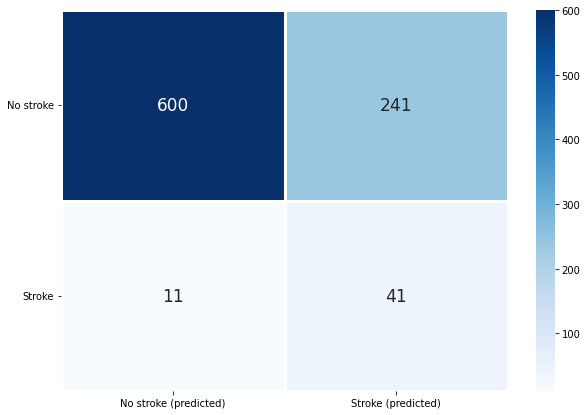

In [11]:
'''
References:
1. https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
2. https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976
3. https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
4. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html
'''

# Training and testing a logistic regression model on the oversampled training data
# logistic_reg_pipeline =  make_pipeline(StandardScaler(), LogisticRegression(random_state = 42))
# logistic_reg_pipeline.fit(X_train_oversampled, y_train_oversampled.values.ravel())
logistic_reg = LogisticRegression(random_state = 42)
logistic_reg.fit(X_train_oversampled, y_train_oversampled.values.ravel())
# y_predicted_lr = logistic_reg_pipeline.predict(X_test_data_scaled)
y_predicted_lr = logistic_reg.predict(X_test_data_scaled)

confusion_matrix_lr = confusion_matrix(y_test_data, y_predicted_lr)
print('Confusion Matrix: ')
print(confusion_matrix_lr)

print('Accuracy (in %): ' + str(logistic_reg.score(X_test_data_scaled, y_test_data)*100))

precision_lr = precision_score(y_test_data, y_predicted_lr)
print('Precision: ' + str(precision_lr))

recall_lr = recall_score(y_test_data, y_predicted_lr)
print('Recall: ' + str(recall_lr))

f1_lr = f1_score(y_test_data, y_predicted_lr)
print('F1 score: ' + str(f1_lr))

# Reference: https://seaborn.pydata.org/generated/seaborn.heatmap.html
plt.figure(figsize = (10, 7))
seaborn.heatmap(confusion_matrix_lr, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 3, cbar = True, annot_kws = {'fontsize': 17},
                xticklabels = ['No stroke (predicted)', 'Stroke (predicted)'], yticklabels = ['No stroke', 'Stroke'])
plt.yticks(rotation = 0)
plt.show()

# Support Vector Classifier on the oversampled training data

Confusion Matrix: 
[[679 162]
 [ 24  28]]
Accuracy (in %): 0.7917133258678611
Precision: 0.14736842105263157
Recall: 0.5384615384615384
F1 score: 0.23140495867768593


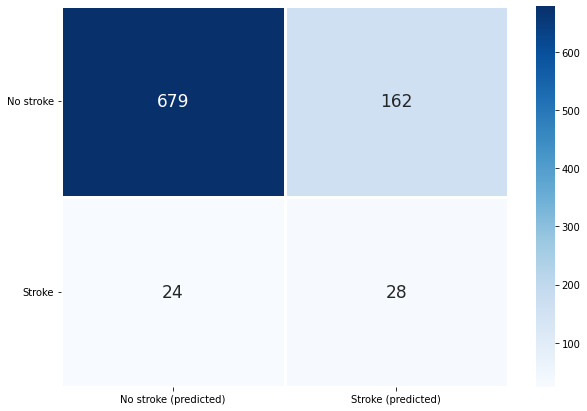

In [12]:
# Training and testing a SVM model on the oversampled training data
#svc_pipeline =  make_pipeline(StandardScaler(), SVC(random_state = 42))
#svc_pipeline.fit(X_train_oversampled, y_train_oversampled.values.ravel())

svc = SVC(random_state = 42)
svc.fit(X_train_oversampled, y_train_oversampled.values.ravel())
y_predicted_svc = svc.predict(X_test_data_scaled)

confusion_matrix_svc = confusion_matrix(y_test_data, y_predicted_svc)
print('Confusion Matrix: ')
print(confusion_matrix_svc)

print('Accuracy (in %): ' + str(svc.score(X_test_data_scaled, y_test_data)))

precision_svc = precision_score(y_test_data, y_predicted_svc)
print('Precision: ' + str(precision_svc))

recall_svc = recall_score(y_test_data, y_predicted_svc)
print('Recall: ' + str(recall_svc))

f1_svc = f1_score(y_test_data, y_predicted_svc)
print('F1 score: ' + str(f1_svc))

# Reference: https://seaborn.pydata.org/generated/seaborn.heatmap.html
plt.figure(figsize = (10, 7))
seaborn.heatmap(confusion_matrix_svc, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 3, cbar = True, annot_kws = {'fontsize': 17},
                xticklabels = ['No stroke (predicted)', 'Stroke (predicted)'], yticklabels = ['No stroke', 'Stroke'])
plt.yticks(rotation = 0)
plt.show()

# Logistic Regression on the undersampled training data

Confusion Matrix: 
[[594 247]
 [  8  44]]
Accuracy (in %): 71.44456886898097
Precision: 0.15120274914089346
Recall: 0.8461538461538461
F1 score: 0.2565597667638484


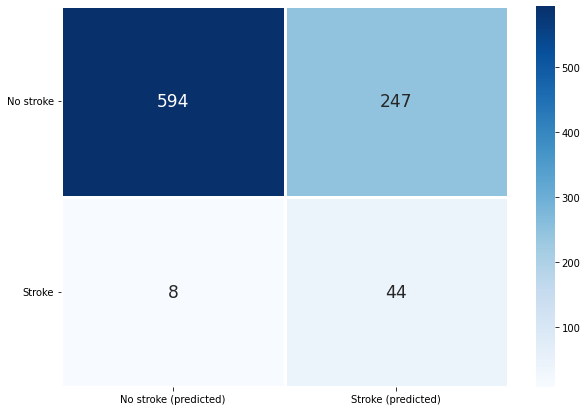

In [13]:
# Training and testing a Logistic Regression model on the undersampled training data
logistic_reg_undersampled = LogisticRegression(random_state = 42)
logistic_reg_undersampled.fit(X_train_undersampled, y_train_undersampled.values.ravel())
# y_predicted_lr = logistic_reg_pipeline.predict(X_test_data_scaled)
y_predicted_lr_us = logistic_reg_undersampled.predict(X_test_data_scaled)

confusion_matrix_lr_us = confusion_matrix(y_test_data, y_predicted_lr_us)
print('Confusion Matrix: ')
print(confusion_matrix_lr_us)

print('Accuracy (in %): ' + str(logistic_reg_undersampled.score(X_test_data_scaled, y_test_data)*100))

precision_lr_us = precision_score(y_test_data, y_predicted_lr_us)
print('Precision: ' + str(precision_lr_us))

recall_lr_us = recall_score(y_test_data, y_predicted_lr_us)
print('Recall: ' + str(recall_lr_us))

f1_lr_us = f1_score(y_test_data, y_predicted_lr_us)
print('F1 score: ' + str(f1_lr_us))

# Reference: https://seaborn.pydata.org/generated/seaborn.heatmap.html
plt.figure(figsize = (10, 7))
seaborn.heatmap(confusion_matrix_lr_us, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 3, cbar = True, annot_kws = {'fontsize': 17},
                xticklabels = ['No stroke (predicted)', 'Stroke (predicted)'], yticklabels = ['No stroke', 'Stroke'])
plt.yticks(rotation = 0)
plt.show()

# Support Vector Classifier on the undersampled training data

Confusion Matrix: 
[[552 289]
 [  9  43]]
Accuracy (in %): 0.6662933930571109
Precision: 0.12951807228915663
Recall: 0.8269230769230769
F1 score: 0.22395833333333334


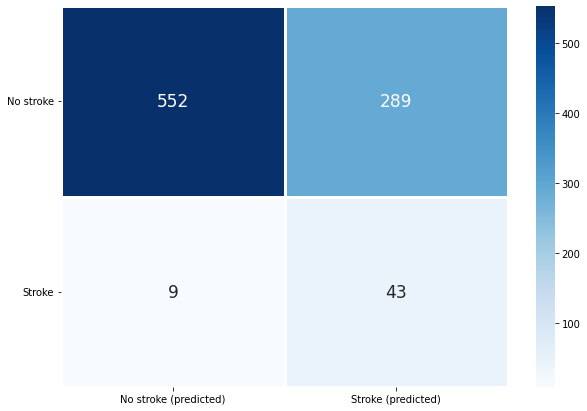

In [14]:
# Training and testing a SVM model on the undersampled training data
svc_undersampled = SVC(random_state = 42)
svc_undersampled.fit(X_train_undersampled, y_train_undersampled.values.ravel())
y_predicted_svc_us = svc_undersampled.predict(X_test_data_scaled)

confusion_matrix_svc_us = confusion_matrix(y_test_data, y_predicted_svc_us)
print('Confusion Matrix: ')
print(confusion_matrix_svc_us)

print('Accuracy (in %): ' + str(svc_undersampled.score(X_test_data_scaled, y_test_data)))

precision_svc_us = precision_score(y_test_data, y_predicted_svc_us)
print('Precision: ' + str(precision_svc_us))

recall_svc_us = recall_score(y_test_data, y_predicted_svc_us)
print('Recall: ' + str(recall_svc_us))

f1_svc_us = f1_score(y_test_data, y_predicted_svc_us)
print('F1 score: ' + str(f1_svc_us))

# Reference: https://seaborn.pydata.org/generated/seaborn.heatmap.html
plt.figure(figsize = (10, 7))
seaborn.heatmap(confusion_matrix_svc_us, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 3, cbar = True, annot_kws = {'fontsize': 17},
                xticklabels = ['No stroke (predicted)', 'Stroke (predicted)'], yticklabels = ['No stroke', 'Stroke'])
plt.yticks(rotation = 0)
plt.show()

# Neural network on the oversampled training data

In [15]:
# Training and testing neural network on the oversampled training data
nn_model = keras.Sequential([
    keras.layers.Dense(17, input_dim=17, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.001, beta_1 = 0.9, beta_2=0.99 , epsilon=1e-05,amsgrad=False,name='Adam'
        ), loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_oversampled, y_train_oversampled.values.ravel(), epochs=500)
    
print(nn_model.evaluate(X_test_data_scaled, y_test_data))
    
y_predicted_nn_model = nn_model.predict(X_test_data_scaled)
y_predicted_nn_model = numpy.round(y_predicted_nn_model)
    
print("Classification Report: \n", classification_report(y_test_data, y_predicted_nn_model))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Epoch 1/500
211/211 [==============================] - 1s 1ms/step - loss: 0.6688 - accuracy: 0.5964
Epoch 2/500
211/211 [==============================] - 0s 1ms/step - loss: 0.5795 - accuracy: 0.7139
Epoch 3/500
211/211 [==============================] - 0s 1ms/step - loss: 0.5078 - accuracy: 0.7681
Epoch 4/500
211/211 [==============================] - 0s 2ms/step - loss: 0.4794 - accuracy: 0.7787
Epoch 5/500
211/211 [==============================] - 0s 1ms/step - loss: 0.4679 - accuracy: 0.7816
Epoch 6/500
211/211 [==============================] - 0s 1ms/step - loss: 0.4601 - accuracy: 0.7824
Epoch 7/500
211/211 [==============================] - 0s 1ms/step - loss: 0.4526 - accuracy: 0.7856
Epoch 8/500
211/211 [==============================] - 0s 1ms/step - loss: 0.4471 - accuracy: 0.7859
Epoch 9/500
211/211 [==============================] - 0s 1ms/step - loss: 0.4415 - accuracy: 0.7908
Epoch 10/500
211/211 [==============================] - 0s 1ms/step - loss: 0.4373 - accura

# Neural network on the undersampled training data

In [16]:
# Training and testing neural network on the undersampled training data
nn_model_us = keras.Sequential([
    keras.layers.Dense(17, input_dim=17, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

nn_model_us.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.001, beta_1 = 0.9, beta_2=0.99 , epsilon=1e-05,amsgrad=False,name='Adam'
        ), loss='binary_crossentropy', metrics=['accuracy'])
nn_model_us.fit(X_train_undersampled, y_train_undersampled.values.ravel(), epochs=500)
    
print(nn_model_us.evaluate(X_test_data_scaled, y_test_data))
    
y_predicted_nn_model_us = nn_model_us.predict(X_test_data_scaled)
y_predicted_nn_model_us = numpy.round(y_predicted_nn_model_us)
    
print("Classification Report: \n", classification_report(y_test_data, y_predicted_nn_model_us))

Epoch 1/500
13/13 [==============================] - 0s 2ms/step - loss: 0.8757 - accuracy: 0.5000
Epoch 2/500
13/13 [==============================] - 0s 2ms/step - loss: 0.7916 - accuracy: 0.4949
Epoch 3/500
13/13 [==============================] - 0s 1ms/step - loss: 0.7416 - accuracy: 0.4949
Epoch 4/500
13/13 [==============================] - 0s 2ms/step - loss: 0.7135 - accuracy: 0.5051
Epoch 5/500
13/13 [==============================] - 0s 2ms/step - loss: 0.6985 - accuracy: 0.5306
Epoch 6/500
13/13 [==============================] - 0s 2ms/step - loss: 0.6866 - accuracy: 0.5663
Epoch 7/500
13/13 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.5689
Epoch 8/500
13/13 [==============================] - 0s 2ms/step - loss: 0.6737 - accuracy: 0.6097
Epoch 9/500
13/13 [==============================] - 0s 2ms/step - loss: 0.6693 - accuracy: 0.6097
Epoch 10/500
13/13 [==============================] - 0s 1ms/step - loss: 0.6637 - accuracy: 0.6224
Epoch 11/

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Decision Trees

['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children', 'Residence_type', 'avg_glucose_level', 'bmi', 'Unknown', 'formerly smoked', 'never smoked', 'smokes', 'stroke']
Confusion Matrix: 
[[645 196]
 [ 13  39]]
Accuracy (in %): 0.7659574468085106
Precision: 0.16595744680851063
Recall: 0.75
F1 score: 0.27177700348432055


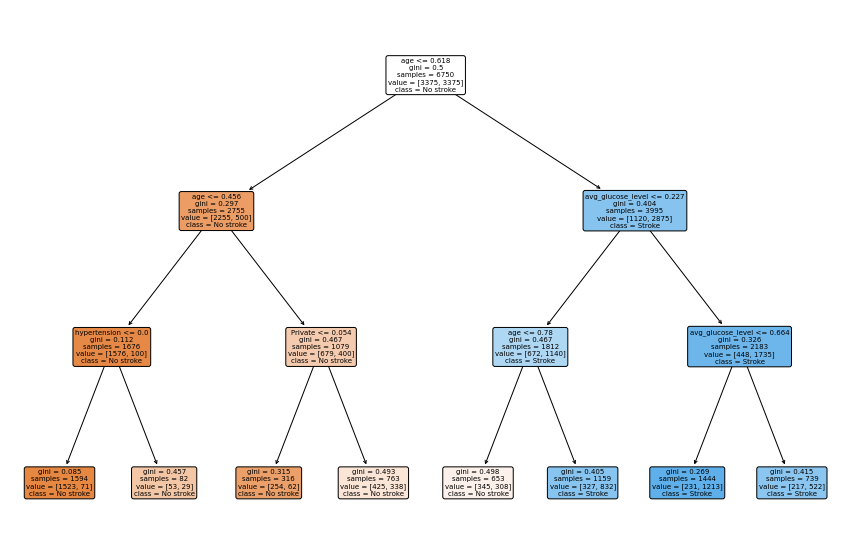

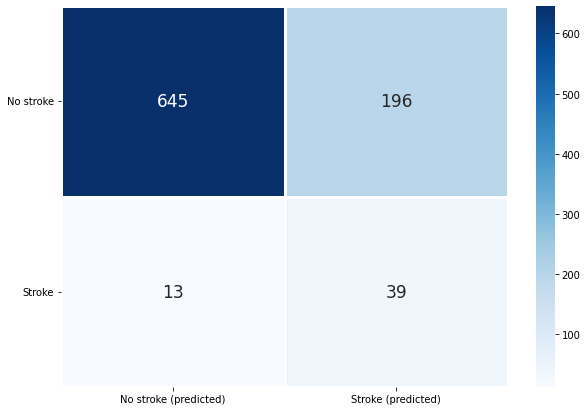

In [18]:
# Training and testing decision trees on the oversampled training data
features = df.columns.tolist()
print(features)
decision_tree_model = DecisionTreeClassifier(criterion="gini", random_state=42, min_samples_leaf=5, max_depth=3)   
decision_tree_model.fit(X_train_oversampled,y_train_oversampled.values.ravel())
y_predicted_dt = decision_tree_model.predict(X_test_data_scaled)
# accuracy_score(y_test,y_predicted_dt)

fig = plt.figure(figsize=(15,10))
tree.plot_tree(decision_tree_model,
               feature_names = features, 
               class_names=["No stroke","Stroke"],
               rounded=True, 
               filled = True);

confusion_matrix_dt = confusion_matrix(y_test_data, y_predicted_dt)
print('Confusion Matrix: ')
print(confusion_matrix_dt)

print('Accuracy (in %): ' + str(decision_tree_model.score(X_test_data_scaled, y_test_data)))

precision_dt = precision_score(y_test_data, y_predicted_dt)
print('Precision: ' + str(precision_dt))

recall_dt = recall_score(y_test_data, y_predicted_dt)
print('Recall: ' + str(recall_dt))

f1_dt = f1_score(y_test_data, y_predicted_dt)
print('F1 score: ' + str(f1_dt))

# Reference: https://seaborn.pydata.org/generated/seaborn.heatmap.html
plt.figure(figsize = (10, 7))
seaborn.heatmap(confusion_matrix_dt, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 3, cbar = True, annot_kws = {'fontsize': 17},
                xticklabels = ['No stroke (predicted)', 'Stroke (predicted)'], yticklabels = ['No stroke', 'Stroke'])
plt.yticks(rotation = 0)
plt.show()

Confusion Matrix: 
[[661 180]
 [ 18  34]]
Accuracy (in %): 0.7782754759238522
Precision: 0.1588785046728972
Recall: 0.6538461538461539
F1 score: 0.2556390977443609


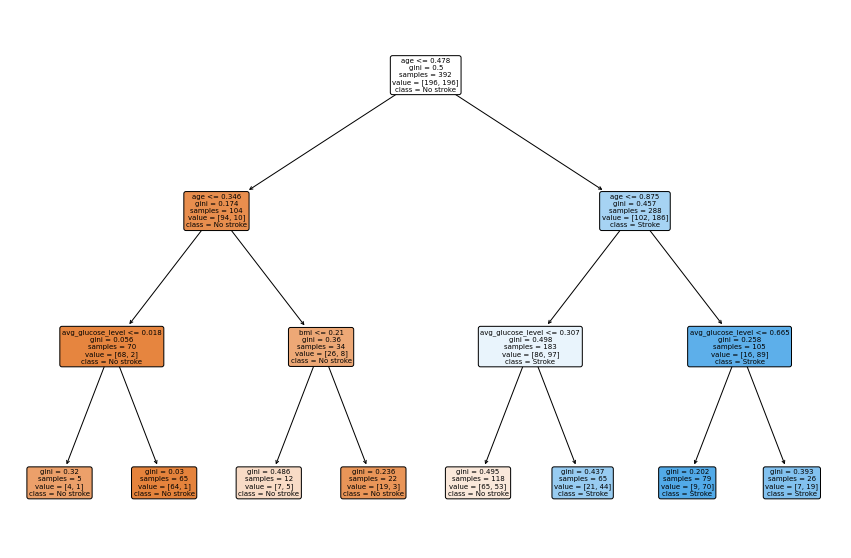

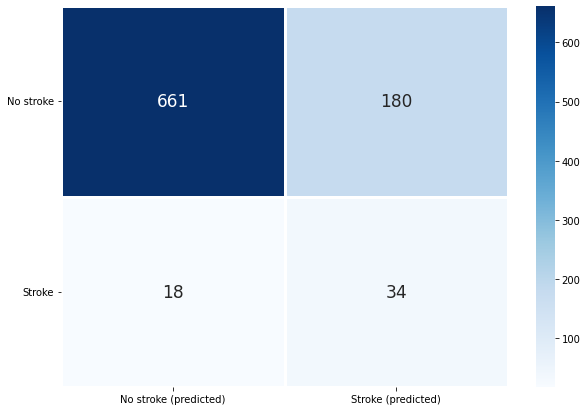

In [19]:
# Training and testing decision trees on the undersampled training data
decision_tree_model_us = DecisionTreeClassifier(criterion="gini", random_state=0, min_samples_leaf=5, max_depth=3)  
decision_tree_model_us.fit(X_train_undersampled,y_train_undersampled.values.ravel())
y_predicted_dt_us = decision_tree_model_us.predict(X_test_data_scaled)
# accuracy_score(y_test,y_predicted_dt)

fig = plt.figure(figsize=(15,10))
tree.plot_tree(decision_tree_model_us,
               feature_names = features, 
               class_names=["No stroke","Stroke"],
               rounded=True, 
               filled = True);

confusion_matrix_dt_us = confusion_matrix(y_test_data, y_predicted_dt_us)
print('Confusion Matrix: ')
print(confusion_matrix_dt_us)

print('Accuracy (in %): ' + str(decision_tree_model_us.score(X_test_data_scaled, y_test_data)))

precision_dt_us = precision_score(y_test_data, y_predicted_dt_us)
print('Precision: ' + str(precision_dt_us))

recall_dt_us = recall_score(y_test_data, y_predicted_dt_us)
print('Recall: ' + str(recall_dt_us))

f1_dt_us = f1_score(y_test_data, y_predicted_dt_us)
print('F1 score: ' + str(f1_dt_us))

# Reference: https://seaborn.pydata.org/generated/seaborn.heatmap.html
plt.figure(figsize = (10, 7))
seaborn.heatmap(confusion_matrix_dt_us, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 3, cbar = True, annot_kws = {'fontsize': 17},
                xticklabels = ['No stroke (predicted)', 'Stroke (predicted)'], yticklabels = ['No stroke', 'Stroke'])
plt.yticks(rotation = 0)
plt.show()

# AdaBoost

Confusion Matrix: 
[[647 194]
 [ 16  36]]
Accuracy (in %): 0.7648376259798432
Precision: 0.1565217391304348
Recall: 0.6923076923076923
F1 score: 0.25531914893617025


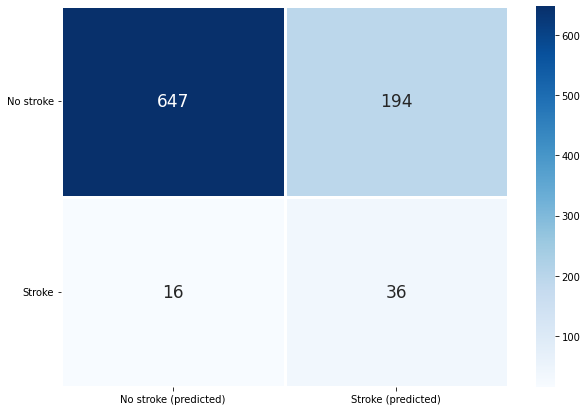

In [20]:
from sklearn.ensemble import AdaBoostClassifier

# Training and testing adaboost on the oversampled training data
adaboost_classifier = AdaBoostClassifier(n_estimators=50, learning_rate=1)
# Train Adaboost Classifer
adaboost_model = adaboost_classifier.fit(X_train_oversampled, y_train_oversampled.values.ravel())

y_predicted_adaboost = adaboost_model.predict(X_test_data_scaled)
# accuracy_score(y_test,y_predicted_dt)

confusion_matrix_adaboost = confusion_matrix(y_test_data, y_predicted_adaboost)
print('Confusion Matrix: ')
print(confusion_matrix_adaboost)

print('Accuracy (in %): ' + str(adaboost_model.score(X_test_data_scaled, y_test_data)))

precision_adaboost = precision_score(y_test_data, y_predicted_adaboost)
print('Precision: ' + str(precision_adaboost))

recall_adaboost = recall_score(y_test_data, y_predicted_adaboost)
print('Recall: ' + str(recall_adaboost))

f1_adaboost = f1_score(y_test_data, y_predicted_adaboost)
print('F1 score: ' + str(f1_adaboost))

# Reference: https://seaborn.pydata.org/generated/seaborn.heatmap.html
plt.figure(figsize = (10, 7))
seaborn.heatmap(confusion_matrix_adaboost, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 3, cbar = True, annot_kws = {'fontsize': 17},
                xticklabels = ['No stroke (predicted)', 'Stroke (predicted)'], yticklabels = ['No stroke', 'Stroke'])
plt.yticks(rotation = 0)
plt.show()

Confusion Matrix: 
[[521 320]
 [ 15  37]]
Accuracy (in %): 0.6248600223964166
Precision: 0.10364145658263306
Recall: 0.7115384615384616
F1 score: 0.18092909535452323


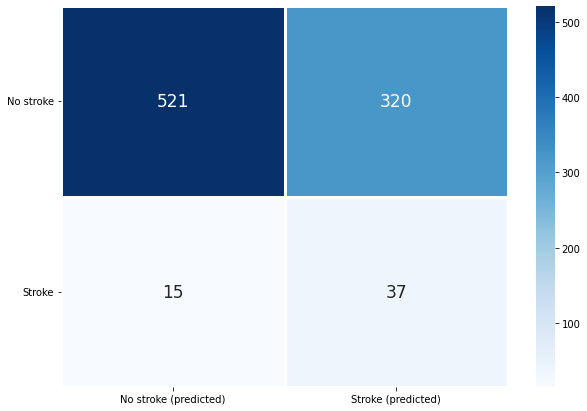

In [21]:
# Training and testing adaboost on the undersampled training data
adaboost_classifier_us = AdaBoostClassifier(n_estimators=50, learning_rate=1)
# Train Adaboost Classifer
adaboost_model_us = adaboost_classifier_us.fit(X_train_undersampled, y_train_undersampled.values.ravel())

y_predicted_adaboost_us = adaboost_model_us.predict(X_test_data_scaled)
# accuracy_score(y_test,y_predicted_dt)

confusion_matrix_adaboost_us = confusion_matrix(y_test_data, y_predicted_adaboost_us)
print('Confusion Matrix: ')
print(confusion_matrix_adaboost_us)

print('Accuracy (in %): ' + str(adaboost_model_us.score(X_test_data_scaled, y_test_data)))

precision_adaboost_us = precision_score(y_test_data, y_predicted_adaboost_us)
print('Precision: ' + str(precision_adaboost_us))

recall_adaboost_us = recall_score(y_test_data, y_predicted_adaboost_us)
print('Recall: ' + str(recall_adaboost_us))

f1_adaboost_us = f1_score(y_test_data, y_predicted_adaboost_us)
print('F1 score: ' + str(f1_adaboost_us))

# Reference: https://seaborn.pydata.org/generated/seaborn.heatmap.html
plt.figure(figsize = (10, 7))
seaborn.heatmap(confusion_matrix_adaboost_us, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 3, cbar = True, annot_kws = {'fontsize': 17},
                xticklabels = ['No stroke (predicted)', 'Stroke (predicted)'], yticklabels = ['No stroke', 'Stroke'])
plt.yticks(rotation = 0)
plt.show()

#  Neural Network additional experiments on the undersampled training data

28/28 [==============================] - 0s 2ms/step - loss: 90.1895 - accuracy: 0.0649 - mse: 0.9343 
[90.189453125, 0.06494960933923721, 0.9342818260192871]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.01      0.01       841
           1       0.06      1.00      0.11        52

    accuracy                           0.06       893
   macro avg       0.53      0.50      0.06       893
weighted avg       0.95      0.06      0.02       893



<AxesSubplot:>

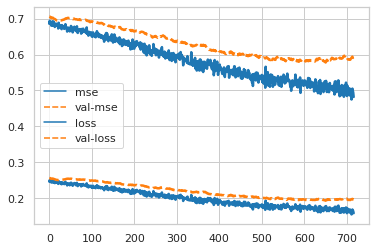

In [22]:
# Implementing neural network with early stopping
from tensorflow_addons import losses
import tensorflow as tf
tf.random.set_seed(432)
from tensorflow import keras
from sklearn.metrics import confusion_matrix , classification_report

model = keras.Sequential([
    keras.layers.Dense(17, input_dim=17, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='sigmoid')
])

'''
model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.0001, beta_1 = 0.9, beta_2=0.99 , epsilon=1e-05,amsgrad=False,name='Adam'
        ), loss='binary_crossentropy', metrics=['accuracy', 'mse'])
hist = model.fit(X_train_undersampled, y_train_undersampled.to_numpy(), validation_split=0.1, verbose=0, epochs=2000)
'''

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=0.01)
model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.0001, beta_1 = 0.9, beta_2=0.99 , epsilon=1e-05,amsgrad=False,name='Adam'
        ), loss='binary_crossentropy', metrics=['accuracy', 'mse'])
hist = model.fit(X_train_undersampled, y_train_undersampled.to_numpy(), validation_split=0.1, verbose=0, epochs=2000, 
                 callbacks=[earlyStopping])

print(model.evaluate(X_test_data, y_test_data))
    
y_preds_undersampled = model.predict(X_test_data)
y_preds_undersampled = numpy.round(y_preds_undersampled)
    
print("Classification Report: \n", classification_report(y_test_data, y_preds_undersampled))

mse = numpy.asarray(hist.history['mse'])
val_mse = numpy.asarray(hist.history['val_mse'])

# Creating the data frame
num_values = (len(mse))
values = numpy.zeros((num_values,2), dtype=float)
values[:,0] = mse
values[:,1] = val_mse

# Using pandas to frame the data
steps = pandas.RangeIndex(start=0,stop=num_values)
data = pandas.DataFrame(values, steps, columns=["mse", "val-mse"])

# Plotting
seaborn.set(style="whitegrid")
seaborn.lineplot(data=data, palette="tab10", linewidth=2.5)


loss = numpy.asarray(hist.history['loss'])
val_loss = numpy.asarray(hist.history['val_loss'])

# Creating the data frame
num_values = (len(loss))
values = numpy.zeros((num_values,2), dtype=float)
values[:,0] = loss
values[:,1] = val_loss

# Using pandas to frame the data
steps = pandas.RangeIndex(start=0,stop=num_values)
data = pandas.DataFrame(values, steps, columns=["loss", "val-loss"])

# Plotting
seaborn.set(style="whitegrid")
seaborn.lineplot(data=data, palette="tab10", linewidth=2.5)

# Neural Network additional experiments on the oversampled training data

28/28 [==============================] - 0s 2ms/step - loss: 161.9515 - accuracy: 0.9429 - mse: 0.0571
[161.9514617919922, 0.9428891539573669, 0.057111579924821854]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       841
           1       1.00      0.02      0.04        52

    accuracy                           0.94       893
   macro avg       0.97      0.51      0.50       893
weighted avg       0.95      0.94      0.92       893



<AxesSubplot:>

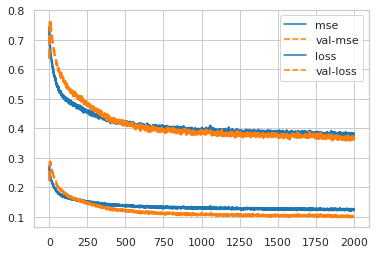

In [23]:
model = keras.Sequential([
    keras.layers.Dense(17, input_dim=17, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.0001, beta_1 = 0.9, beta_2=0.99 , epsilon=1e-05,amsgrad=False,name='Adam'
        ), loss='binary_crossentropy', metrics=['accuracy', 'mse'])
hist = model.fit(X_train_oversampled, y_train_oversampled.to_numpy(), validation_split=0.1, verbose=0, epochs=2000)
    
print(model.evaluate(X_test_data, y_test_data))
    
y_preds_oversampled = model.predict(X_test_data)
y_preds_oversampled = numpy.round(y_preds_oversampled)
    
print("Classification Report: \n", classification_report(y_test_data, y_preds_oversampled))

mse = numpy.asarray(hist.history['mse'])
val_mse = numpy.asarray(hist.history['val_mse'])

# Creating the data frame
num_values = (len(mse))
values = numpy.zeros((num_values,2), dtype=float)
values[:,0] = mse
values[:,1] = val_mse

# Using pandas to frame the data
steps = pandas.RangeIndex(start=0,stop=num_values)
data = pandas.DataFrame(values, steps, columns=["mse", "val-mse"])

# Plotting
seaborn.set(style="whitegrid")
seaborn.lineplot(data=data, palette="tab10", linewidth=2.5)

loss = numpy.asarray(hist.history['loss'])
val_loss = numpy.asarray(hist.history['val_loss'])

# Creating the data frame
num_values = (len(loss))
values = numpy.zeros((num_values,2), dtype=float)
values[:,0] = loss
values[:,1] = val_loss

# Using pandas to frame the data
steps = pandas.RangeIndex(start=0,stop=num_values)
data = pandas.DataFrame(values, steps, columns=["loss", "val-loss"])

# Plotting
seaborn.set(style="whitegrid")
seaborn.lineplot(data=data, palette="tab10", linewidth=2.5)

28/28 [==============================] - 0s 2ms/step - loss: 63.0945 - accuracy: 0.7727 - mse: 0.2272
[63.0944938659668, 0.7726763486862183, 0.22717253863811493]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.80      0.87       841
           1       0.11      0.40      0.17        52

    accuracy                           0.77       893
   macro avg       0.53      0.60      0.52       893
weighted avg       0.91      0.77      0.83       893



<AxesSubplot:>

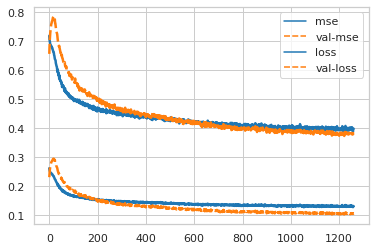

In [24]:
# Implementing Early Stopping

model = keras.Sequential([
    keras.layers.Dense(17, input_dim=17, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='sigmoid')
])
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, min_delta=0.01)
model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.0001, beta_1 = 0.9, beta_2=0.99 , epsilon=1e-05,amsgrad=False,name='Adam'
        ), loss='binary_crossentropy', metrics=['accuracy', 'mse'])
hist = model.fit(X_train_oversampled, y_train_oversampled.to_numpy(), validation_split=0.1, verbose=0, epochs=2000, 
                 callbacks=[earlyStopping])
    
print(model.evaluate(X_test_data, y_test_data))
    
y_preds_oversampled = model.predict(X_test_data)
y_preds_oversampled = numpy.round(y_preds_oversampled)
    
print("Classification Report: \n", classification_report(y_test_data, y_preds_oversampled))

mse = numpy.asarray(hist.history['mse'])
val_mse = numpy.asarray(hist.history['val_mse'])

# Creating the data frame
num_values = (len(mse))
values = numpy.zeros((num_values,2), dtype=float)
values[:,0] = mse
values[:,1] = val_mse

# Using pandas to frame the data
steps = pandas.RangeIndex(start=0,stop=num_values)
data = pandas.DataFrame(values, steps, columns=["mse", "val-mse"])

# Plotting
seaborn.set(style="whitegrid")
seaborn.lineplot(data=data, palette="tab10", linewidth=2.5)


loss = numpy.asarray(hist.history['loss'])
val_loss = numpy.asarray(hist.history['val_loss'])

# Creating the data frame
num_values = (len(loss))
values = numpy.zeros((num_values,2), dtype=float)
values[:,0] = loss
values[:,1] = val_loss

# Using pandas to frame the data
steps = pandas.RangeIndex(start=0,stop=num_values)
data = pandas.DataFrame(values, steps, columns=["loss", "val-loss"])

# Plotting
seaborn.set(style="whitegrid")
seaborn.lineplot(data=data, palette="tab10", linewidth=2.5)